In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.STL10(root='./data', split='train',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.STL10(root='./data', split='test',
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('airplane', 'bird', 'car', 'cat',
           'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


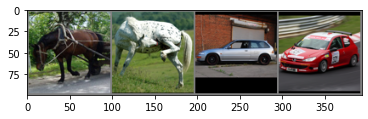

horse horse   car   car


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
import torch


class BasicModule(torch.nn.Module):
    def __init__(self):
        super(BasicModule, self).__init__()
        self.model_name = str(type(self))
        
        self.epoch = 0
        self.lr_pre_epoch = []
        self.loss_pre_epoch = []
        self.valacc_pre_epoch = []
        self.testacc_pre_epoch = []

        
    def load(self, path):
        checkpoint = torch.load(path)
        self.epoch = checkpoint['epoch']
        self.lr_pre_epoch = checkpoint['lr']
        self.loss_pre_epoch = checkpoint['loss']
        self.valacc_pre_epoch = checkpoint['valacc']
        self.testacc_pre_epoch = checkpoint['testacc']
        self.load_state_dict(checkpoint['state_dict'])

        
    def save(self, name = None):
        if name is None:
            name = './' + self.model_name
        else:    
            name = './' + name
            
        
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr_pre_epoch,
            'loss': self.loss_pre_epoch,
            'valacc': self.valacc_pre_epoch,
            'testacc': self.testacc_pre_epoch,
            'state_dict': self.state_dict(),
        }, name)
        
        return name
    
    def update_epoch(self, lr_, loss_, valacc_, testacc_):
        self.epoch += 1
        self.lr_pre_epoch.append(lr_)
        self.loss_pre_epoch.append(loss_)
        self.valacc_pre_epoch.append(valacc_)
        self.testacc_pre_epoch.append(testacc_)
        assert len(self.lr_pre_epoch) == len(self.loss_pre_epoch) == len(self.valacc_pre_epoch) == len(self.testacc_pre_epoch)
       
    def epoches(self):
        return len(self.lr_pre_epoch)

In [5]:
import torch
from torch import nn
import torch.nn.functional as F

class ALL_CNN(BasicModule): #https://github.com/Eulring/ALL-CNN-on-CIFAR10
    
    def __init__(self, num_classes = 10):
        
        super(ALL_CNN, self).__init__()
        
        self.model_name = 'ALL_CNN'
        
        self.dp0 = nn.Dropout2d(p = 0.2)
        
        self.conv1 = nn.Conv2d(3, 96, 3, padding = 1)
        #self.bn1 = nn.BatchNorm2d(96)
        
        self.conv2 = nn.Conv2d(96, 96, 3, padding = 1)
        #self.bn2 = nn.BatchNorm2d(96)

        self.conv3 = nn.Conv2d(96, 96, 3, stride = 2, padding = 1)
        self.dp1 = nn.Dropout2d(p = 0.5)
        #self.bn3 = nn.BatchNorm2d(96)
        
        self.conv4 = nn.Conv2d(96, 192, 3, padding = 1)
        #self.bn4 = nn.BatchNorm2d(192)
        
        self.conv5 = nn.Conv2d(192, 192, 3, padding = 1)
        #self.bn5 = nn.BatchNorm2d(192)
        
        self.conv6 = nn.Conv2d(192, 192, 3, stride = 2, padding = 1)
        self.dp2 = nn.Dropout2d(p = 0.5)
        #self.bn6 = nn.BatchNorm2d(192)
        
        
        
        self.conv7 = nn.Conv2d(192, 192, 3, padding = 0)
        #self.bn7 = nn.BatchNorm2d(192)
        
        self.conv8 = nn.Conv2d(192, 192, 1)
        #self.bn8 = nn.BatchNorm2d(192)
        
        self.conv9 = nn.Conv2d(192, 10, 1)
        #self.bn9 = nn.BatchNorm2d(10)
        
        self.avg = nn.AvgPool2d(6)
        
        
        nn.init.xavier_normal_(self.conv1.weight)
        nn.init.xavier_normal_(self.conv2.weight)
        nn.init.xavier_normal_(self.conv3.weight)
        nn.init.xavier_normal_(self.conv4.weight)
        nn.init.xavier_normal_(self.conv5.weight)
        nn.init.xavier_normal_(self.conv6.weight)
        nn.init.xavier_normal_(self.conv7.weight)
        nn.init.xavier_normal_(self.conv8.weight)
        nn.init.xavier_normal_(self.conv9.weight)
        
        '''
        for m in self.modules():
            name = m.__class__.__name__
            if name.find is 'Conv':
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
        '''
        
    def forward(self, x):
        
        # x = self.dp0(x)
        
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = F.relu(self.conv3(x))
        #print(x.shape)
        # x = self.dp1(x)
        
        
        x = F.relu(self.conv4(x))
        #print(x.shape)
        x = F.relu(self.conv5(x))
        #print(x.shape)
        x = F.relu(self.conv6(x))
        #print(x.shape
        # x = self.dp2(x)
        
        
        x = F.relu(self.conv7(x))
        #print(x.shape)
        x = F.relu(self.conv8(x))
        #print(x.shape)
        x = F.relu(self.conv9(x))
        #x = self.bn3(x)
        #print(x.shape)
        x = self.avg(x)
        x = torch.squeeze(x)
        return x

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
            
        )

        self.dp0 = nn.Dropout2d(p = 0.7)

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)


class GoogLeNet(nn.Module): #https://github.com/kuangliu/pytorch-cifar
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def test():
    net = GoogLeNet()
    x = torch.randn(1,3,32,32)
    y = net(x)
    print(y.size())

In [7]:
import warnings

class DefaultConfig(object):
    
    checkpoint_load_name = None
    checkpoint_save_name = None
    
    
    stage1 = 10
    stage2 = 10
    stage3 = 5
    stage4 = 5
    
    lr1 = 0.15
    lr2 = 0.1
    lr3 = 0.05
    lr4 = 0.01
    
    test_model_path = '.'
    use_trained_model = False
    
# used for transform learning    
    tl_data_path = '.'
    tl_point = None
    class_id = 2
    
    use_clip = True
    clip = 2.0

    
# config of training 1
    batch_size = 128
    use_gpu = True
    num_workers = 4
    print_freq = 5000
    debug_mode = True
    num_train = 49000
    data_aug = False
    heavy_aug = False
    use_cutout = False
    auto_aug = False

# config of training 2
    max_epoch = 20
    lr = 0.01
    lr_decay = 0.9
    weight_decay = 0
    

def parse(self, kwargs):
# update the config according to kwargs
    for k, v in kwargs.items():
        if not hasattr(self, k):
            warnings.warn("Warning: opt has not attribut %s" % k)
        setattr(self, k, v)

    print('user config:')
    for k, v in self.__class__.__dict__.items():
        if not k.startswith('__'):
            print(k, getattr(self, k))

DefaultConfig.parse = parse
opt = DefaultConfig()

In [8]:
import torch
import numpy as np


def ZCA_W(x):
# Input Matrix should be the shape of (N x 32 x 32 x 3)
    x = torch.Tensor(x)
    x = x.numpy()
    x = np.transpose(x, (0, 3, 1, 2))
    x = torch.tensor(x)
    
    s0, s1, s2, s3 = x.size(0), x.size(1), x.size(2), x.size(3)

    X = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
    X = X - X.mean(dim=0)
    sigma = torch.mm(X.t(), X) / X.size(0)
    u, s, _ = np.linalg.svd(sigma.numpy())
    epsilon = 1e-5

    ss = torch.Tensor(np.diag(1. / np.sqrt(s + epsilon)))
    u = torch.Tensor(u)
    zca_matrix = torch.mm(torch.mm(u, ss), u.t())

    print(zca_matrix.shape)

    nx = torch.mm(zca_matrix, X.t()).t()
    
    nx = nx.view(s0, s1, s2, s3)
    
    nx = nx.numpy()
    nx = np.transpose(nx, (0, 2, 3, 1))
    #nx = torch.tensor(nx)
    
    
    return nx


class Cutout(object): # https://github.com/uoguelph-mlrg/Cutout
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [9]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random

class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]


    def __call__(self, img):
        if random.random() < self.p1: img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2: img = self.operation2(img, self.magnitude2)
        return img

class AutoAugment(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.
        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as T

import os
import argparse

from torch.utils.data import DataLoader
from torch.utils.data import sampler
from tqdm import tqdm

import torchvision.datasets as dset

import numpy as np
import easydict
 
args = easydict.EasyDict({
        "lr": 0.1,
        "resume": False,
})

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
NUM_TRAIN = 49000

transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

train_transform = T.Compose([])
if opt.data_aug == True:
    print("data augmentation")
    train_transform.transforms.append(T.RandomCrop(32, padding=4))
    train_transform.transforms.append(T.RandomHorizontalFlip())
    train_transform.transforms.append(T.RandomHorizontalFlip())
if opt.data_aug == True and opt.heavy_aug == True:
    print("heavy")
    train_transform.transforms.append(T.RandomAffine(degrees=22.5, translate=None, scale=(1.2, 1.2), shear=8.59, resample=0, fillcolor=0))
if opt.data_aug == True and opt.auto_aug == True:
    train_transform.transforms.insert(0, AutoAugment())       
train_transform.transforms.append(T.ToTensor())
train_transform.transforms.append(T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)))
if opt.data_aug == True and opt.use_cutout == True:
    train_transform.transforms.append(Cutout(n_holes=1, length=16))

# Model
print('==> Building model..')
# net = ALL_CNN()
# net = ResNet18()
net = GoogLeNet()
# net = densenet_cifar()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr,
                      momentum=0.9, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(loader_train):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx+1 == len(loader_train):
          print('Batch [{}/{}], Loss: {:.4f}, Acc :{: f} ({}/{})'
          .format(batch_idx+1, len(loader_train), (train_loss/(batch_idx+1)), 100.*correct/total, correct, total))

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        print("test")
        for batch_idx, (inputs, targets) in enumerate(loader_test):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx+1 == len(loader_test):
              print('Batch [{}/{}], Loss: {:.4f}, Acc :{: f} ({}/{})' 
              .format(batch_idx+1, len(loader_test), (test_loss/(batch_idx+1)), 100.*correct/total, correct, total))
          

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..


In [19]:
for epoch in range(start_epoch, start_epoch+30):
    train(epoch)
    valid(epoch)
    test(epoch)
    scheduler.step()


Epoch: 0
Batch [192/192], Loss: 2.0021, Acc : 26.367347 (6460/24500)
valid
Batch [1/8], Loss: 2.1331, Acc : 34.375000 (44/128)
Batch [2/8], Loss: 2.0870, Acc : 33.203125 (85/256)
Batch [3/8], Loss: 2.0817, Acc : 32.552083 (125/384)
Batch [4/8], Loss: 2.0802, Acc : 32.421875 (166/512)
Batch [5/8], Loss: 2.0500, Acc : 32.656250 (209/640)
Batch [6/8], Loss: 2.0623, Acc : 32.031250 (246/768)
Batch [7/8], Loss: 2.0627, Acc : 32.031250 (287/896)
Batch [8/8], Loss: 2.0592, Acc : 32.100000 (321/1000)
Saving..
test
Batch [79/79], Loss: 2.0641, Acc : 30.540000 (3054/10000)

Epoch: 1
Batch [192/192], Loss: 1.6162, Acc : 40.506122 (9924/24500)
valid
Batch [1/8], Loss: 1.4589, Acc : 47.656250 (61/128)
Batch [2/8], Loss: 1.4632, Acc : 48.828125 (125/256)
Batch [3/8], Loss: 1.5009, Acc : 48.958333 (188/384)
Batch [4/8], Loss: 1.5063, Acc : 48.046875 (246/512)
Batch [5/8], Loss: 1.5121, Acc : 47.656250 (305/640)
Batch [6/8], Loss: 1.5294, Acc : 46.744792 (359/768)
Batch [7/8], Loss: 1.5418, Acc : 45.